In [1]:
## Read polygons from file and apply as gee geometries
import fiona
from shapely.geometry import shape, MultiPolygon, Polygon
import glob

# current working directory
import os
cwd = os.getcwd()

# find files in shapefile folder
shape_file_path = '../../TreeTect/data/shapefiles_waterbodies_osm/*.shp'
shape_files = glob.glob(shape_file_path)
path = shape_files[1]

shape_files, cwd, path

(['../../TreeTect/data/shapefiles_waterbodies_osm/Cilegon_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Denpasar_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Test area CGI.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Balikpapan_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Medan_water_areas.shp',
  '../../TreeTect/data/shapefiles_waterbodies_osm/Jakarta_water_areas.shp'],
 '/home/chris/Documents/GreenCityWatch/GCW_toolkit/GBDX_local',
 '../../TreeTect/data/shapefiles_waterbodies_osm/Denpasar_water_areas.shp')

In [2]:
shp_AOIs = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 
id_list = [pol['id'] for pol in fiona.open(path)]

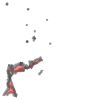

In [4]:
shp_AOIs

In [5]:
import csv

from gbdxtools.task import env
from gbdxtools import Interface, CatalogImage
import gbdx_auth

# gbdx_auth = gbdx_auth.get_session('/home/chris/.gbdx-config/credentials')

gbdx = Interface()


%matplotlib inline

In [33]:
geom = shp_AOIs[0]

In [34]:
# convert to wkt
wkt_string = geom.wkt

In [35]:
# define filters for GBDX search
filters = [
        "(sensorPlatformName ='WORLDVIEW02' OR sensorPlatformName ='WORLDVIEW03')",
        "cloudCover < 50" # AND coverage > 50"
]

In [36]:
t_max = datetime.datetime.strptime('2019-08-08', '%Y-%m-%d')

In [37]:
# create search window 
window = 200

search_start = t_max - datetime.timedelta(days = window) 
search_end = t_max + datetime.timedelta(days = window)


str_search_start = search_start.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
str_search_end = search_end.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

print("Start: " + str_search_start + "\nEnd: " + str_search_end)

Start: 2019-01-20T00:00:00.000000Z
End: 2020-02-24T00:00:00.000000Z


In [28]:
results = gbdx.catalog.search(searchAreaWkt=wkt_string,
                          startDate=str_search_start,
                          endDate=str_search_end,
                          filters=filters)

In [38]:
len(results)

23

In [57]:
from shapely.geometry import MultiPolygon
from shapely.wkt import dumps, loads

import numpy as np

In [58]:
import pandas as pd

df = pd.DataFrame(columns=['id', 'image_id', 'cloud_cover', 'overlap', 'd_time', 'ordered'])

In [60]:
from tqdm import tqdm_notebook

i = 0



for result in tqdm_notebook(results):
    image_id = result['identifier']
    cloudCover = result['properties']['cloudCover']
    ordered = CatalogImage.is_available(image_id)
    shape_image = loads(result['properties']['footprintWkt'])
    
    # Get timestamp
    time_image = result["properties"]["timestamp"] 

    # convert timestamp to datetime timestamp format
    time_image = datetime.datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")

    time_diff = time_image - t_max
    
    overlap_fraction = round(shape_image.intersection(geom).area/geom.area,2)

    # Pass the row elements as key value pairs to append() function 
    df = df.append({'id' : i , 
                             'image_id' : image_id,
                             'cloud_cover' : cloudCover,
                             'overlap' : overlap_fraction,
                             'd_time' : time_diff,
                             'ordered' : ordered},
                            ignore_index=True)
    
    
   #  print(df.loc[i])
    
    i = i + 1

In [71]:
# check if images are available or if ordering is needed
len(df[df['ordered']  == True])

12

In [74]:
df_sorted = df.sort_values(['ordered','overlap', 'cloud_cover', 'd_time'] ,ascending=[False, False, True, True])

image_id = df_sorted.loc[0].image_id

In [78]:
# get the right bbox for gbdx tools search
bbox = env.inputs.get('bbox', ', '.join(map(str, geom.bounds))) #.buffer(0.0001)
bbox = env.inputs.get('bbox', bbox)

In [ ]:
## Get image from GBDX

# order if not ordered
# otherwise print error and check

try:
    print("Try to get image from GBDX...")
    image = CatalogImage(image_id, bbox=map(float, bbox.split(",")), pansharpen = False)
    
    print("Success")
except:
    
    print("Check if image is ordered... ")
    
    ordered = CatalogImage.is_available(image_id)
    
    if not ordered:
        order_id = gbdx.ordering.order(image_id)
        
 
        with open('order_id_{}.csv'.format(image_id), 'w+', newline='') as File:  
            order_writer = csv.writer(File)
            order_writer.writerow('image_id: ' + image_id + ' order_id: ' + order_id)
            
            reader = csv.reader(File)
            for row in reader:
                print(row)
                
        print("Image {} ordered with order id: {}".format(image_id, order_id))
                
    else:
        print("Image ordered is: {}".format(ordered))


        print('Image error')

Try to get image from GBDX...


In [ ]:
# Get timestamp
time_image = image.metadata["image"]["acquisitionDate"] 

# convert timestamp to datetime timestamp format
time_image = datetime.datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")

time_image

In [ ]:
print("World View image taken on {}".format( image.metadata["image"]["acquisitionDate"]))
print('Time difference between target {} and image is: {}'.format(t_max, time_image - t_max)

In [ ]:
x,y = geom.centroid.xy

# UTM zone and EPSG code calculator
zone_cal = round((183+x[0])/6,0)
EPSG = 32700-round((45+y[0])/90,0)*100+round((183+x[0])/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)

UTM_EPSG_code

In [ ]:
name = 'test_water'

path = "../../TreeTect/data/rasters_waterbodies_osm/{}_pansharpen_{}_{}.tif".format(name,time_image_str,image_id)
proj = UTM_EPSG_code

path

In [ ]:
tif = image.geotiff(
    path = path, 
    proj = proj
                 )
print('image downloaded to' + path)